## My functions

In [515]:
def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number+1)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values, target_points

def create_cumulative_event(rainfall, interval=0.5):
    if rainfall is None:
        return None, None
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    cumulative_rainfall = [0] + cumulative_rainfall
    
    # Generate corresponding time points
    time_points = np.arange(0, len(rainfall) + 1) * interval
    
    return  [0] + cumulative_rainfall.tolist(), time_points.tolist()

def create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times):

    # Step 3: Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

#     # Step 4: Calculate the cumulative event duration
#     # Since each time step is 30 minutes, we multiply the index by 0.5 (for hours)
#     time_step = 0.5  # 30 minutes = 0.5 hours
#     cumulative_duration = np.arange(1, len(cumulative_rainfall) + 1) * time_step
    
#     # Step 5: Normalize the cumulative duration by the total event duration
#     total_event_duration = cumulative_duration[-1]
#     normalized_cumulative_duration = cumulative_duration / total_event_duration

    total_event_time = cumulative_rainfall_times[-1]
    normalized_cumulative_rainfall_times = np.array(cumulative_rainfall_times) / total_event_time
    normalized_cumulative_rainfall_times
    
    return normalized_cumulative_rainfall, normalized_cumulative_rainfall_times


def find_intensity_as_proportion_of_mean_event(incremental_rainfall):
    mean_over_event = np.mean(incremental_rainfall)
    irain = incremental_rainfall/np.mean(incremental_rainfall)
    return irain


def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    return raw_rainfall[1:]

## Steef's functions

In [511]:
import numpy as np
import matplotlib.pyplot as plt
import os

from Create_Profiles_Functions import *

def get_normalised_intensity(array_in, len_out):
    len_in = len(array_in)
    # Calculates the total accumulated value at each original point
    # Adds a zero at the start of the array
    csum = np.cumsum(np.hstack((np.array([0.0]), array_in)))
    # Normalise accumulation to 0 to 1
    csum = csum / csum[-1]
    # Array going from 0 up to 1: normalised time
    # corresponding to these points
    normalised_time_in = np.arange(len_in + 1) / (1.0 * len_in)
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    normalised_time_out = np.arange(len_out + 1) / (1.0 * len_out)
    # Interpolate total accumulated value to desired output points
    csum_out = np.interp(normalised_time_out, normalised_time_in, csum)
    # Interpolate back to accumulations over the desired number of intervals
    # Scale with the number of points to normalise
    normalised_intensity = (csum_out[1:] - csum_out[:-1]) * len_out
    return normalised_intensity

def get_normalised_intensity_mine(array_in, len_out):
    len_in = len(array_in)
    
    ############### Same as create cumulative event
    # Calculates the total accumulated value at each original point
    # Adds a zero at the start of the array
    csum = np.cumsum(np.hstack((np.array([0.0]), array_in)))
    ###############

    ############### Same as create_dimensionless_event
    # Normalise accumulation to 0 to 1
    csum = csum / csum[-1]
    # Array going from 0 up to 1: normalised time
    # corresponding to these points
    normalised_time_in = np.arange(len_in + 1) / (1.0 * len_in)
    ###############

    ############### Same as interpolate_rainfall
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    normalised_time_out = np.arange(len_out + 1) / (1.0 * len_out)
    # Interpolate total accumulated value to desired output points
    csum_out = np.interp(normalised_time_out, normalised_time_in, csum)
    ###############

    ############### Same as convert back to incremental rainfall, but get rid of the first value?
    # Interpolate back to accumulations over the desired number of intervals
    # Scale with the number of points to normalise
    incremental = (csum_out[1:] - csum_out[:-1]) 
    ###############
    ###############  Finds intensity as a proprtion of mean event intensity
    mean_over_event = np.mean(incremental)
    irain = incremental/mean_over_event
     
    return incremental #, normalised_time_out


def plot_normalised_intensity(normalised_intensity, category):
    len_intensity = len(normalised_intensity)
    # Time points: start of event, end of event, midpoint of the intervals
    plot_time = np.hstack(
        (
            np.array([0.0]),
            (np.arange(len_intensity) + 0.5) / len_intensity,
            np.array([1.0]),
        )
    )
    # The way Roberto plots the curve, going to 0 at start/end
    extended_intensity = np.hstack(
        (np.array([0.0]), normalised_intensity, np.array([0.0]))
    )
    # Alternative plotting method, which keeps intensity constant at start/end
    # Advantage is that this gives the correct integral under the curve
    # Though it still has some issues (probably every plotting method has issues)
    # extended_intensity_v2 = np.hstack(
    #    (
    #        np.array(normalised_intensity[0]),
    #        normalised_intensity,
    #        np.array(normalised_intensity[-1]),
    #    )
    # )
    plt.plot(plot_time, extended_intensity)
    # plt.plot(plot_time, extended_intensity_v2)
    plt.scatter(plot_time, extended_intensity)
    plt.xlim(0, 1)
    plt.ylim(bottom=0.0)
    plt.xlabel("normalised time")
    plt.ylabel("normalised intensity")
    # plt.legend(("RVH et al.", "alternative"))
    plt.title("event curve, category = " + str(category))
    plt.show()

def analyse_event(array_in):
    # Remove leading/trailing zeros from array
    # can we always do this?
    trimmed_array = np.trim_zeros(array_in)
    # Go from raw data directly to 12 and 5 points
    event_curve_12 = get_normalised_intensity(trimmed_array, 12)
    event_curve_5 = get_normalised_intensity(trimmed_array, 5)
    # Get the category as a number from 1 to 5
    # add 1 as python indexing starts at 0
    category = np.argmax(event_curve_5) + 1
    return category, event_curve_12

def redistribute(array_in,len_out):
    len_in=len(array_in)
    # Array going from 0 up to and including the number of original points
    in_bounds=np.arange(len_in+1)
    # Calculates the total accumulated value at each original point
    # Adds a zero for point zero
    csum=np.cumsum(np.hstack((np.array([0.]),array_in)))
    # Array of the "time points" corresponding to
    # Boundaries of output intervals
    out_bounds=np.arange(len_out+1)*(len_in/(1.0*len_out))
    # Interpolate total accumulated value to desired output points
    csum_out=np.interp(out_bounds,in_bounds,csum)
    # Interpolate back to accumulations over the desired number of intervals
    array_out=csum_out[1:]-csum_out[:-1]
    return array_out

## Comparing two methods

In [ ]:
fp = '/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/NIMROD_2.2km_filtered_100/0/WholeYear/EventSet/0.5hrs_2008_v2_part0.csv'
this_event = read_event(gauge_num, fp)
precip = this_event['precipitation (mm)']

### Using my method

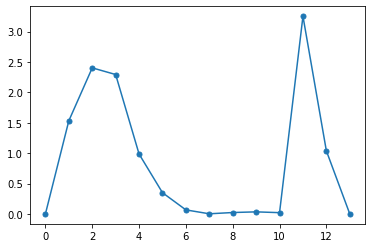

In [519]:
cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
interpolated15_cumulative_rainfall, interpolated15_times = interpolate_rainfall(dimensionless_cumulative_rainfall,15)
interpolated12_cumulative_rainfall, interpolated12_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
interpolated5_cumulative_rainfall, interpolated5_times = interpolate_rainfall(dimensionless_cumulative_rainfall,5)

interpolated15_incremental_rainfall = create_incremental_event(interpolated15_cumulative_rainfall)
interpolated12_incremental_rainfall = create_incremental_event(interpolated12_cumulative_rainfall)
interpolated5_incremental_rainfall = create_incremental_event(interpolated5_cumulative_rainfall)

max_quintile_profile_12 = find_part_with_most_rain(interpolated12_incremental_rainfall, 5)
max_quintile_profile_5 = find_part_with_most_rain(interpolated5_incremental_rainfall, 5)

irain = find_intensity_as_proportion_of_mean_event(interpolated12_incremental_rainfall)
irain = np.append([0], irain)
irain = np.append(irain, [0])
plt.plot(irain, marker = '.', markersize=10)

In [525]:
max_quintile_profile_5

1

In [517]:
interpolated5_incremental_rainfall

array([0.40361262, 0.2211567 , 0.01134026, 0.00481611, 0.3590743 ])

### Using Steef's method

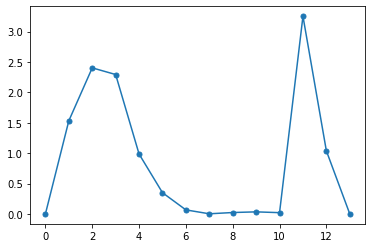

In [521]:
category, event_curve_12 = analyse_event(precip)
event_curve_12 = np.append([0], event_curve_12)
event_curve_12 = np.append(event_curve_12, [0])
plt.plot(event_curve_12, marker = '.', markersize=10)

In [524]:
event_curve_12

array([0.        , 1.53262443, 2.40339627, 2.29356579, 0.98545519,
       0.34912091, 0.06611942, 0.00208839, 0.02287141, 0.03379433,
       0.02074557, 3.25267236, 1.03754595, 0.        ])

In [522]:
event_curve_5 = get_normalised_intensity_mine(precip, 5)
category = np.argmax(event_curve_5) + 1
event_curve_5

array([0.40361262, 0.2211567 , 0.01134026, 0.00481611, 0.3590743 ])

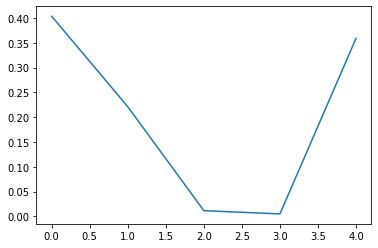

In [528]:
plt.plot(event_curve_5)

### Comparing methods

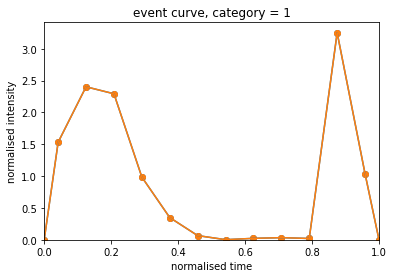

In [498]:
def plot_normalised_intensity(normalised_intensity, category):
    len_intensity = len(normalised_intensity)
    # Time points: start of event, end of event, midpoint of the intervals
    plot_time = np.hstack((np.array([0.0]),
            (np.arange(len_intensity) + 0.5) / len_intensity,
            np.array([1.0]),))
    
    # The way Roberto plots the curve, going to 0 at start/end
    extended_intensity = np.hstack(
        (np.array([0.0]), normalised_intensity, np.array([0.0])))

    plt.plot(plot_time, extended_intensity)
    # plt.plot(plot_time, extended_intensity_v2)
    plt.scatter(plot_time, extended_intensity)
    plt.xlim(0, 1)
    plt.ylim(bottom=0.0)
    plt.xlabel("normalised time")
    plt.ylabel("normalised intensity")
    # plt.legend(("RVH et al.", "alternative"))
    plt.title("event curve, category = " + str(category))
    
plot_normalised_intensity(event_curve_12, category)    
plot_normalised_intensity(irain, category)    